In [1]:
# Standard library imports
import multiprocessing as mp
import logging
import hydra
from dotenv import load_dotenv
from tqdm import tqdm 

# Third-party imports
import wandb
from jax import random as jr

# Foundational SSM imports
from omegaconf import OmegaConf

from foundational_ssm.utils.downstream_utils import (
    mse_loss_downstream,
    train_one_epoch,
    validate_one_epoch,
    log_predictions_and_activations,
    get_nlb_datasets,
    load_training_state,
    create_optimizer_and_state,
    train_one_batch
)
from foundational_ssm.models import SSMDownstreamDecoder
import multiprocessing as mp
import equinox as eqx
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import pandas as pd



model_cls = SSMDownstreamDecoder
dataset_cfg = OmegaConf.create({
    'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_prepend_train.h5',
    'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_prepend_val.h5',
    'batch_size': 64,
    'phase': 'validation',
    'skip_timesteps': 60
})
model_cfg = OmegaConf.create({
    'input_dim': 130,
    'ssm_io_dim': 256,
    'ssm_init_diag_blocks': 4,
    'ssm_num_layers': 1,
    'output_dim': 2,
    'rng_seed': 42,
    'dt_min': 0.001,
    'dt_max': 0.01,
    'dropout_p': 0.03,
    'ssm_dropout_p': 0.03,
    'context_dim': 0,
    'ssm_ux_width_ratio': 2,
    'init': 'muP'
})
optimizer_cfg = OmegaConf.create({
    'lr': 0.002,
    'weight_decay': 0.01,
    'mode': 'standard'
})

ssm_io_dims = [32, 64, 128, 256, 512, 1024]
parameterizations = ['muP', 'standard']
skip_timesteps=60

In [ ]:
from foundational_ssm.utils import mup
from foundational_ssm.utils.mup import MupMeta, build_mup_meta
from typing import Any, Optional
import jax.tree as jt
base_model, state = eqx.nn.make_with_state(model_cls)(**model_cfg)
base_params = eqx.filter(base_model, eqx.is_array)

target_model_cfg = model_cfg.copy() 


  0%|          | 0/7 [00:00<?, ?it/s]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 7/7 [01:42<00:00, 14.66s/it]


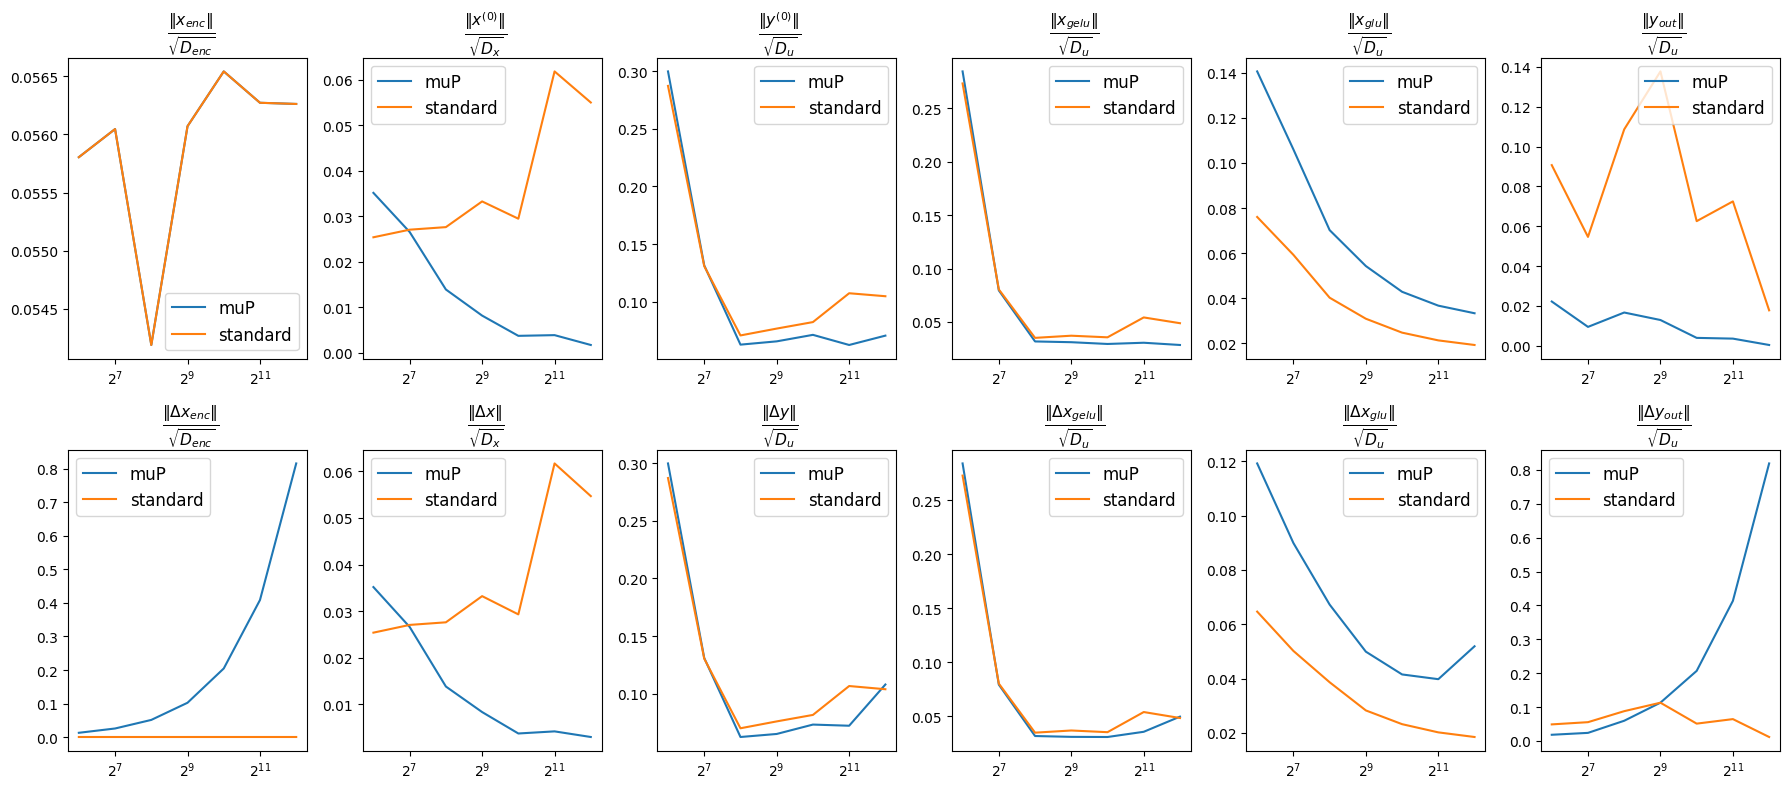

In [ ]:
results = []
layer_keys = ["post_encoder","ssm_x", "ssm_y", "ssm_post_gelu", "ssm_post_glu", "pre_decoder"] 

train_data, val_data, data = get_nlb_datasets(dataset_cfg, jr.PRNGKey(42)) 
activation_generation_input = train_data['neural_input'][:32, :skip_timesteps+1]

activation_timestep = skip_timesteps

for ssm_io_dim in tqdm(ssm_io_dims):
    for parameterization in tqdm(parameterizations):
        target_model_cfg['ssm_io_dim'] = ssm_io_dim
        optimizer_cfg['mode'] = 'all' if parameterization != 'muP' else parameterization
        
        target_model, state = eqx.nn.make_with_state(model_cls)(**target_model_cfg)
        target_params = eqx.filter(target_model, eqx.is_array)
        mup_meta, target_model = mup.infer_and_apply_mup(base_params, target_params)
        
        
        model, state = eqx.nn.make_with_state(model_cls)(**model_cfg)
        inf_downstream_model = eqx.nn.inference_mode(model)
        # ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
        
        # generate activations
        inf_model = eqx.nn.inference_mode(model) # Switches off dropout
        opt, opt_state, lr_scheduler = create_optimizer_and_state(model, 
                                                                    optimizer_cfg,
                                                                    model_cfg)
        init_out, _, init_activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(activation_generation_input, state, layer_keys)
        
        #take one step
        model =  eqx.nn.inference_mode(model, False)
        model, state, opt_state, batch_loss = train_one_batch(
                train_data, model, state,
                mse_loss_downstream, opt, opt_state, jr.PRNGKey(42), lr_scheduler, 0,
                skip_timesteps, wandb_logging=False
            )
        
        # generate activations again 
        inf_model = eqx.nn.inference_mode(model) # Switches off dropout
        opt, opt_state, lr_scheduler = create_optimizer_and_state(model, 
                                                                    optimizer_cfg,
                                                                    model_cfg)
        step_1_out, _, step_1_activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(activation_generation_input, state, layer_keys)
        
        # compute norm per activation key 
        activation_norm = {k+'_norm': jnp.mean(jnp.linalg.norm(init_activations[k][:,activation_timestep,:], axis=1)) / jnp.sqrt(init_activations[k].shape[-1]) for k in init_activations.keys()}
        activation_diff_norm = {k+'_diff_norm': jnp.mean(jnp.linalg.norm(step_1_activations[k][:,activation_timestep,:] - init_activations[k][:,activation_timestep,:], axis=1)) / jnp.sqrt(init_activations[k].shape[-1]) for k in init_activations.keys()}
        
        _results = {
            'parameterization': parameterization,
            'ssm_io_dim': ssm_io_dim,
            'input': jnp.mean(jnp.linalg.norm(activation_generation_input[:,activation_timestep,:], axis=1)) / jnp.sqrt(activation_generation_input.shape[-1]),
            'output_norm': jnp.mean(jnp.linalg.norm(init_out[:,activation_timestep,:], axis=1)) / jnp.sqrt(init_out.shape[-1]),
            'output_diff_norm': jnp.mean(jnp.linalg.norm(step_1_out[:,activation_timestep,:] - init_out[:,activation_timestep,:], axis=1)) / jnp.sqrt(init_out.shape[-1])
        }
        _results.update(activation_norm)
        _results.update(activation_diff_norm) 
        results.append(_results)


results_df = pd.DataFrame(results)
results_df.columns
norms_titles = {
    'post_encoder_norm': r' $\frac{\|x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_norm': r' $\frac{\|x^{(0)}\|}{\sqrt{D_{x}}}$',
    'ssm_y_0_norm': r' $\frac{\|y^{(0)}\|}{\sqrt{D_{u}}}$',
    'ssm_post_gelu_0_norm': r' $\frac{\|x_{gelu}\|}{\sqrt{D_{u}}}$',
    'ssm_post_glu_0_norm': r' $\frac{\|x_{glu}\|}{\sqrt{D_{u}}}$',
    'output_norm': r' $\frac{\|y_{out}\|}{\sqrt{D_{u}}}$',
    'post_encoder_diff_norm': r' $\frac{\|\Delta x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_diff_norm': r' $\frac{\|\Delta x\|}{\sqrt{D_{x}}}$',
    'ssm_y_0_diff_norm': r' $\frac{\|\Delta y\|}{\sqrt{D_{u}}}$',
    'ssm_post_gelu_0_diff_norm': r' $\frac{\|\Delta x_{gelu}\|}{\sqrt{D_{u}}}$',
    'ssm_post_glu_0_diff_norm': r' $\frac{\|\Delta x_{glu}\|}{\sqrt{D_{u}}}$',
    'output_diff_norm': r' $\frac{\|\Delta y_{out}\|}{\sqrt{D_{u}}}$'
}

fig, axs = plt.subplots(2, 6, figsize=(18, 8))
axs = axs.flatten()
for p, (col, title) in enumerate(norms_titles.items()):
    ax = axs[p]
    for parameterization in parameterizations:
        subset = results_df[results_df['parameterization'] == parameterization]
        ax.plot(subset['ssm_io_dim'], subset[col], label=parameterization)
    ax.set_title(title, fontsize=16)
    # ax.set_xlabel('SSM IO Dimension', fontsize=14)
    ax.set_xscale('log', base=2)
    ax.legend(fontsize=12)
    
fig.tight_layout()

100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


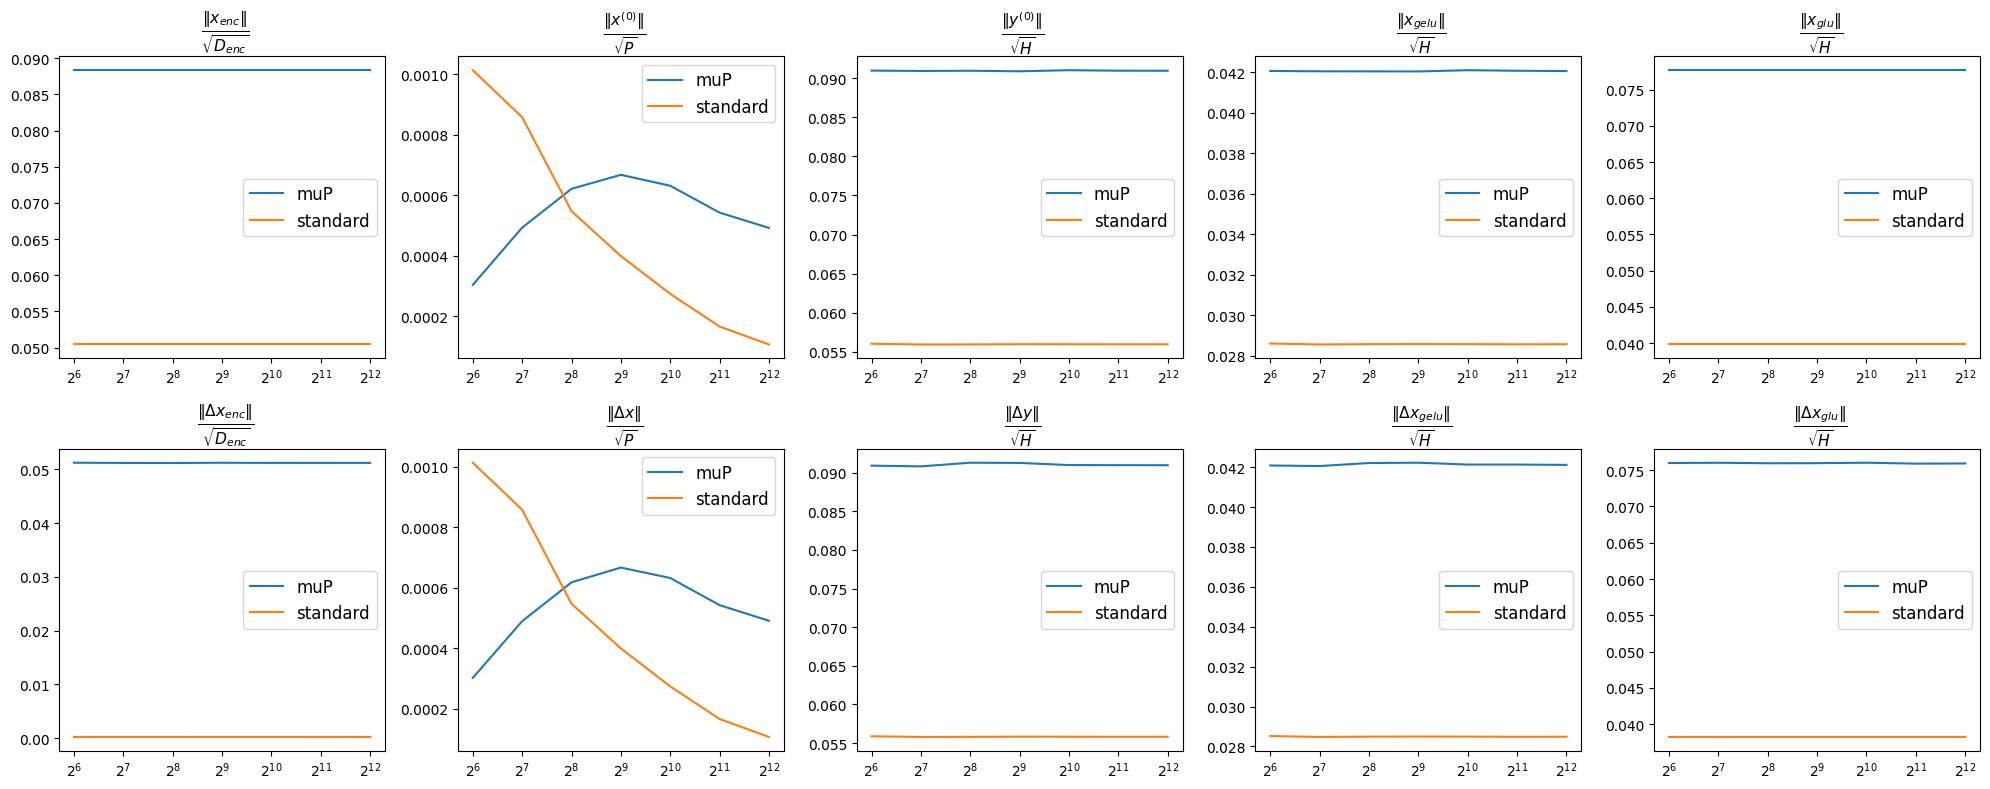

In [34]:
results = []
layer_keys = ["post_encoder","ssm_x", "ssm_y", "ssm_post_gelu", "ssm_post_glu", "pre_decoder"] 

train_data, val_data, data = get_rtt_datasets(dataset_cfg, jr.PRNGKey(42)) 
activation_generation_input = train_data['neural_input'][:32]

activation_timestep = 0
model_cfg['ssm_io_dim'] = 256
for ssm_dim in tqdm(ssm_dims):
    for parameterization in tqdm(parameterizations):
        model_cfg['ssm_dim'] = ssm_dim
        model_cfg['init'] = parameterization 
        optimizer_cfg['mode'] = 'all' if parameterization != 'muP' else parameterization
        model, state = eqx.nn.make_with_state(model_cls)(**model_cfg)
        inf_downstream_model = eqx.nn.inference_mode(model)
        # ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
        
        # generate activations
        inf_model = eqx.nn.inference_mode(model) # Switches off dropout
        opt, opt_state, lr_scheduler = create_optimizer_and_state(model, 
                                                                    optimizer_cfg,
                                                                    model_cfg)
        _, _, init_activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(activation_generation_input, state, layer_keys)
        
        #take one step
        model =  eqx.nn.inference_mode(model, False)
        model, state, opt_state, batch_loss = train_one_batch(
                train_data, model, state,
                mse_loss_downstream, opt, opt_state, jr.PRNGKey(42), lr_scheduler, 0,
                skip_timesteps, wandb_logging=False
            )
        
        # generate activations again 
        inf_model = eqx.nn.inference_mode(model) # Switches off dropout
        opt, opt_state, lr_scheduler = create_optimizer_and_state(model, 
                                                                    optimizer_cfg,
                                                                    model_cfg)
        _, _, step_1_activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(activation_generation_input, state, layer_keys)
        
        # compute norm per activation key 
        activation_norm = {k+'_norm': jnp.mean(jnp.linalg.norm(init_activations[k][:,activation_timestep,:], axis=1)) / jnp.sqrt(init_activations[k].shape[-1]) for k in init_activations.keys()}
        activation_diff_norm = {k+'_diff_norm': jnp.mean(jnp.linalg.norm(step_1_activations[k][:,activation_timestep,:] - init_activations[k][:,activation_timestep,:], axis=1)) / jnp.sqrt(init_activations[k].shape[-1]) for k in init_activations.keys()}
        
        _results = {
            'parameterization': parameterization,
            'ssm_dim': ssm_dim,
            'x_in': jnp.mean(jnp.linalg.norm(activation_generation_input[:,activation_timestep,:], axis=1)) / jnp.sqrt(activation_generation_input.shape[-1])
        }
        _results.update(activation_norm)
        _results.update(activation_diff_norm) 
        results.append(_results)


results_df = pd.DataFrame(results)
results_df.columns
norms_titles = {
    'post_encoder_norm': r' $\frac{\|x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_norm': r' $\frac{\|x^{(0)}\|}{\sqrt{P}}$',
    'ssm_y_0_norm': r' $\frac{\|y^{(0)}\|}{\sqrt{H}}$',
    'ssm_post_gelu_0_norm': r' $\frac{\|x_{gelu}\|}{\sqrt{H}}$',
    'ssm_post_glu_0_norm': r' $\frac{\|x_{glu}\|}{\sqrt{H}}$',
    'post_encoder_diff_norm': r' $\frac{\|\Delta x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_diff_norm': r' $\frac{\|\Delta x\|}{\sqrt{P}}$',
    'ssm_y_0_diff_norm': r' $\frac{\|\Delta y\|}{\sqrt{H}}$',
    'ssm_post_gelu_0_diff_norm': r' $\frac{\|\Delta x_{gelu}\|}{\sqrt{H}}$',
    'ssm_post_glu_0_diff_norm': r' $\frac{\|\Delta x_{glu}\|}{\sqrt{H}}$'
}

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for p, (col, title) in enumerate(norms_titles.items()):
    ax = axs[p]
    for parameterization in parameterizations:
        subset = results_df[results_df['parameterization'] == parameterization]
        ax.plot(subset['ssm_dim'], subset[col], label=parameterization)
    ax.set_title(title, fontsize=16)
    # ax.set_xlabel('SSM IO Dimension', fontsize=14)
    ax.set_xscale('log', base=2)
    ax.legend(fontsize=12)
    
fig.tight_layout()

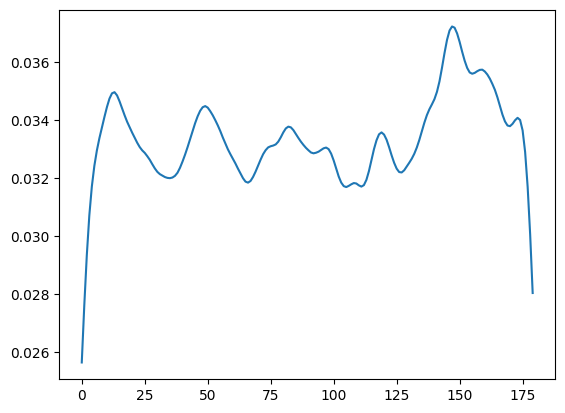

In [36]:
plt.plot(jnp.mean(jnp.linalg.norm(step_1_activations['ssm_y_0'], axis=2) , axis=0))